## Derivatives Pricing : 

The goal this analysis project is to perform derivative pricing with machine learning and use supervised regression based model to learn Black Scholes option from simulated data

the Black Scholes Formula used here is

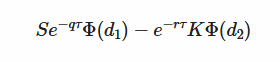

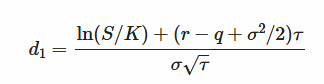

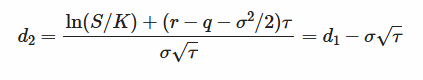

here Stock Price is S

Strike PRice is K

Risk free rate is r

Annual dividend yield is q

Time to maturity is = T-t

Volatility = sigma

Moneyness = M = (K/S)

q is set to be 0

In [ ]:
# Distribution functions
from scipy.stats import norm


# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

## True Parameters

In [12]:
true_alpha = 0.1
true_beta = 0.1
true_sigma0 = 0.2
risk_free_rate = 0.05

## Option Pricing and Volatility Functions :


In [14]:
def option_vol_from_surface(moneyness, time_to_maturity):
    return true_sigma0 + true_alpha * time_to_maturity + true_beta * np.square(moneyness - 1)

def call_option_price(moneyness, time_to_maturity, option_vol):
    d1=(np.log(1/moneyness)+(risk_free_rate+np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    d2=(np.log(1/moneyness)+(risk_free_rate-np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    return N_d1 - moneyness * np.exp(-risk_free_rate*time_to_maturity) * N_d2

In [16]:
N = 10000

Ks = 1+0.25*np.random.randn(N)
Ts = np.random.random(N)
Sigmas = np.array([option_vol_from_surface(k,t) for k,t in zip(Ks,Ts)])
Ps = np.array([call_option_price(k,t,sig) for k,t,sig in zip(Ks,Ts,Sigmas)])

In [18]:
Y = Ps

X = np.concatenate([Ks.reshape(-1,1), Ts.reshape(-1,1), Sigmas.reshape(-1,1)], axis=1)

dataset = pd.DataFrame(np.concatenate([Y.reshape(-1,1), X], axis=1),
                       columns=['Price', 'Moneyness', 'Time', 'Vol'])

<h1>EDA : </h1>

## Descriptive Stats :

In [20]:
dataset.head()

,Price,Moneyness,Time,Vol
0,0.150941,0.924642,0.343303,0.234898
1,0.114470,1.089331,0.502039,0.251002
2,0.217951,1.073106,0.951304,0.295665
3,0.105660,1.223508,0.681750,0.273171
4,0.172715,1.054062,0.705236,0.270816


In [26]:
pd.set_option('display.precision', 3)
dataset.describe()

,Price,Moneyness,Time,Vol
count,10000.000,10000.000,1.000e+04,10000.000
mean,0.179,0.997,4.980e-01,0.256
std,0.136,0.251,2.865e-01,0.030
min,0.000,0.117,1.427e-05,0.200
25%,0.074,0.830,2.505e-01,0.231
50%,0.162,0.994,4.989e-01,0.256
75%,0.254,1.167,7.414e-01,0.281
max,0.885,1.918,1.000e+00,0.363


## Visualization : 

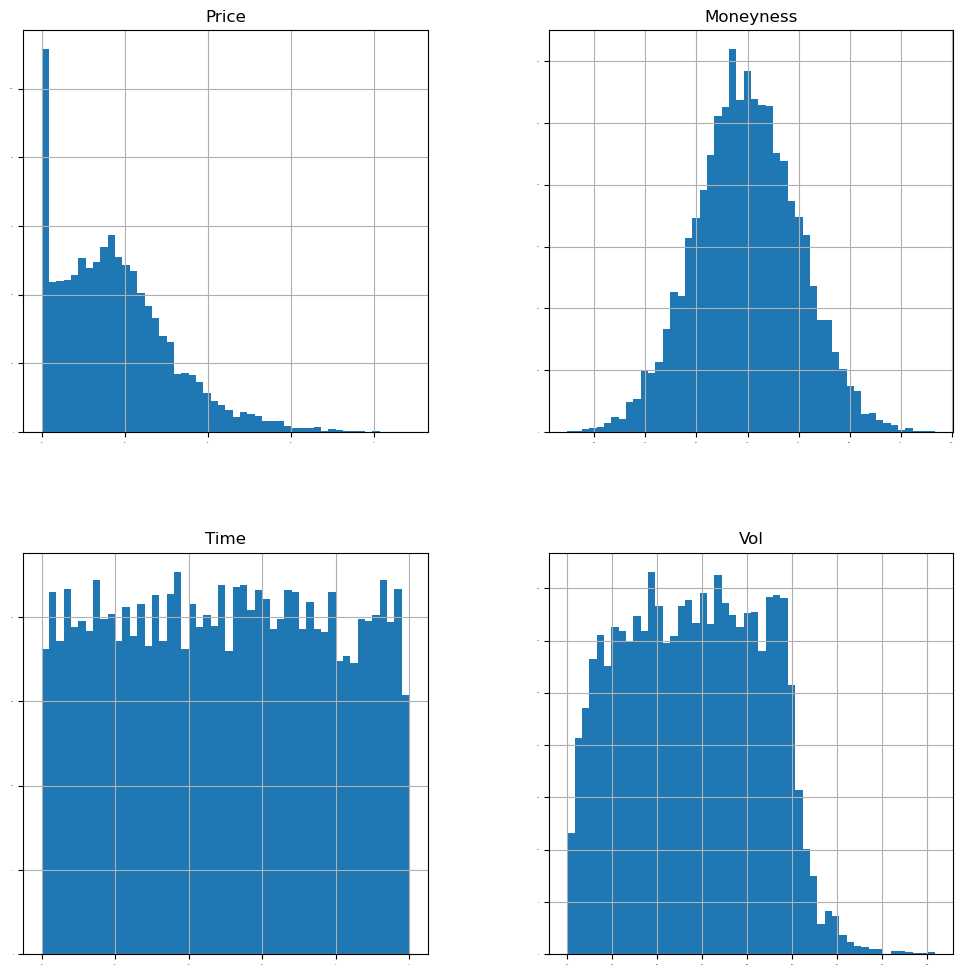

In [28]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

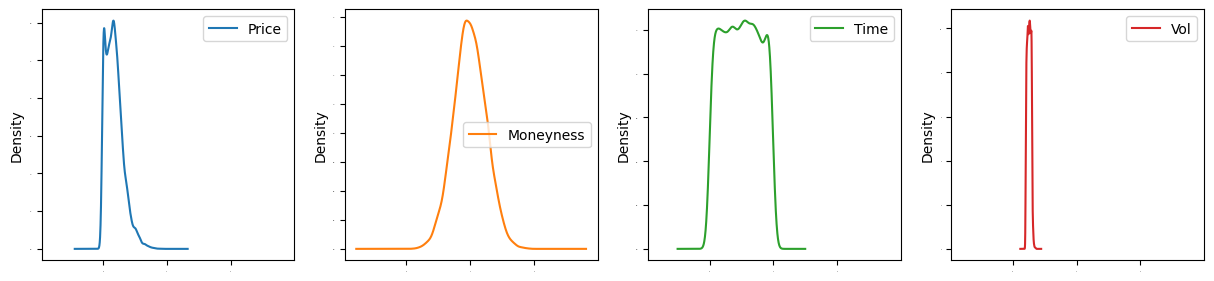

In [30]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

<Axes: title={'center': 'Correlation Matrix'}>

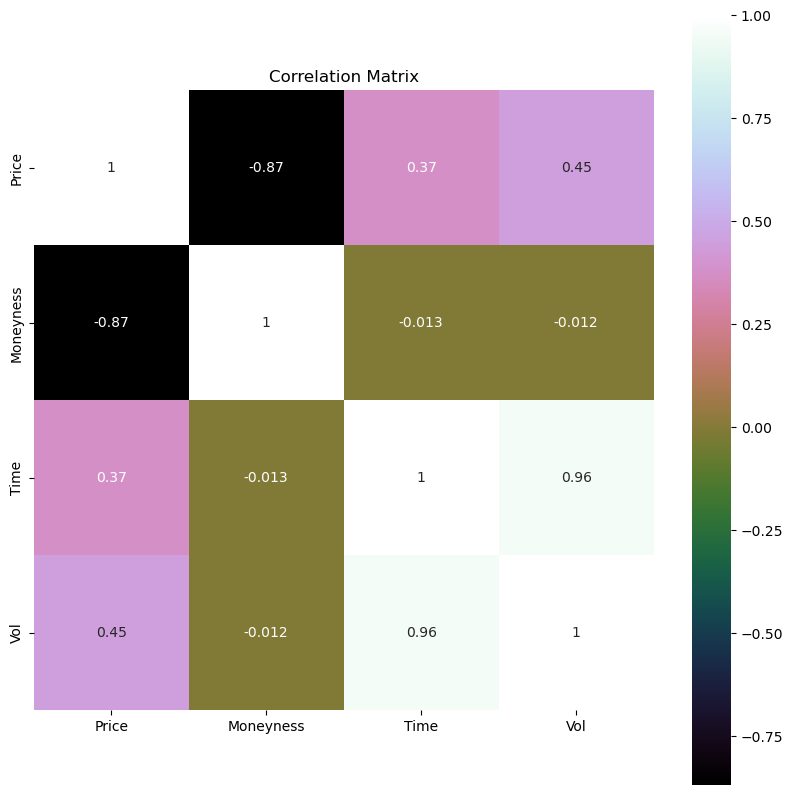

In [32]:
correlation = dataset.corr()
pyplot.figure(figsize=(10,10))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1500x1500 with 0 Axes>

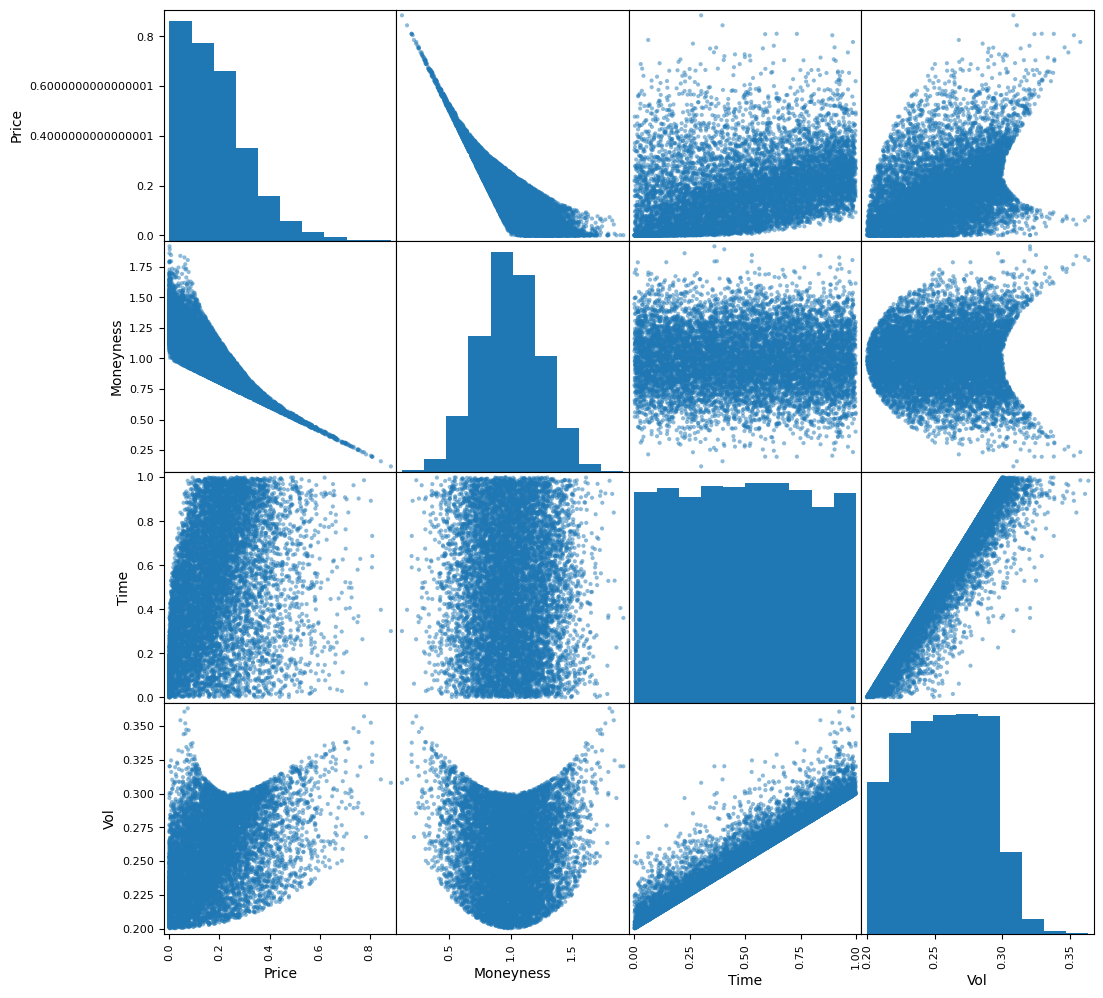

In [34]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

## univariate feature selection : 

In [38]:
from sklearn.feature_selection import SelectKBest, f_regression
bestfeatures = SelectKBest(k='all', score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(['Moneyness', 'Time', 'Vol'])
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
Moneyness,30772.679
Vol,2487.002
Time,1609.226


## train test split 

In [40]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [55]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

## Linear Models and Regression Trees : 

In [56]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

## Neural Network Predictor :

In [57]:
models.append(('MLP', MLPRegressor()))

## Boosting And Bagging Method  :

In [58]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [60]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000356 (0.000027) 0.000355 0.000352
LASSO: 0.018543 (0.001172) 0.018541 0.018189
EN: 0.018543 (0.001172) 0.018541 0.018189
KNN: 0.000016 (0.000010) 0.000009 0.000011
CART: 0.000012 (0.000004) 0.000000 0.000010
SVR: 0.004626 (0.000124) 0.004644 0.004602
MLP: 0.000041 (0.000035) 0.000028 0.000023
ABR: 0.000636 (0.000052) 0.000637 0.000615
GBR: 0.000022 (0.000003) 0.000018 0.000022
RFR: 0.000003 (0.000003) 0.000000 0.000002
ETR: 0.000001 (0.000003) 0.000000 0.000000


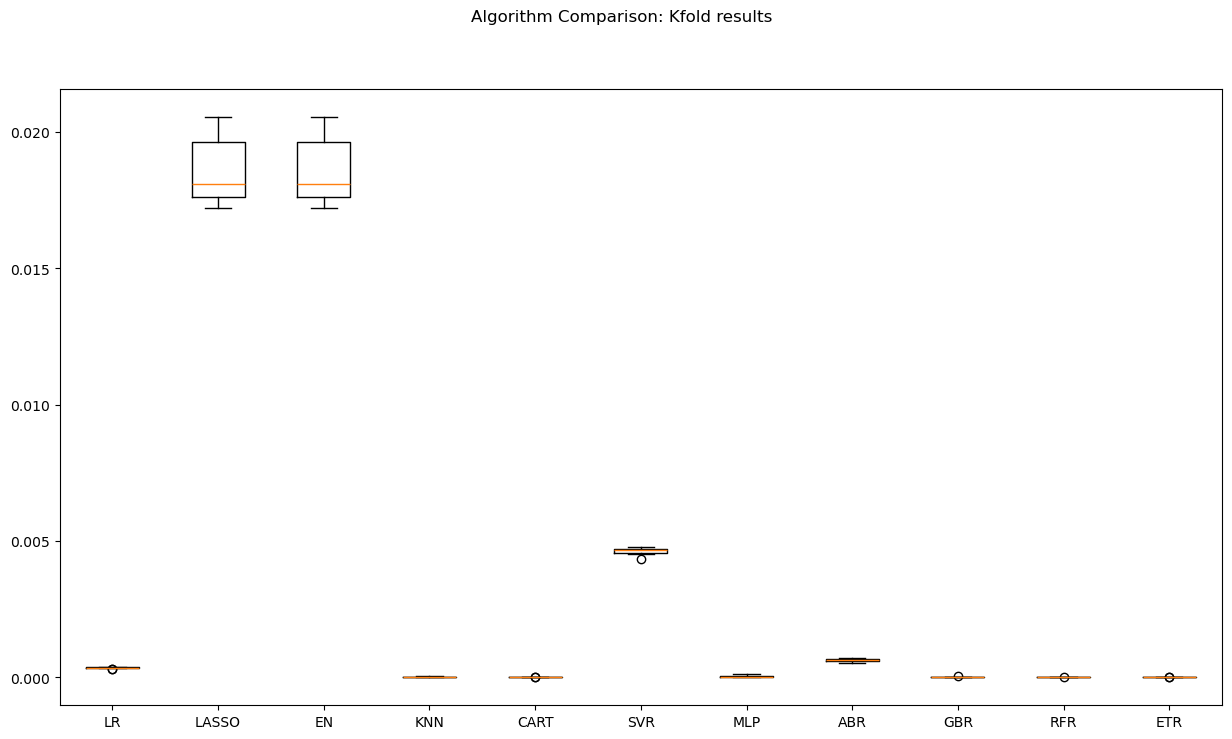

In [62]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

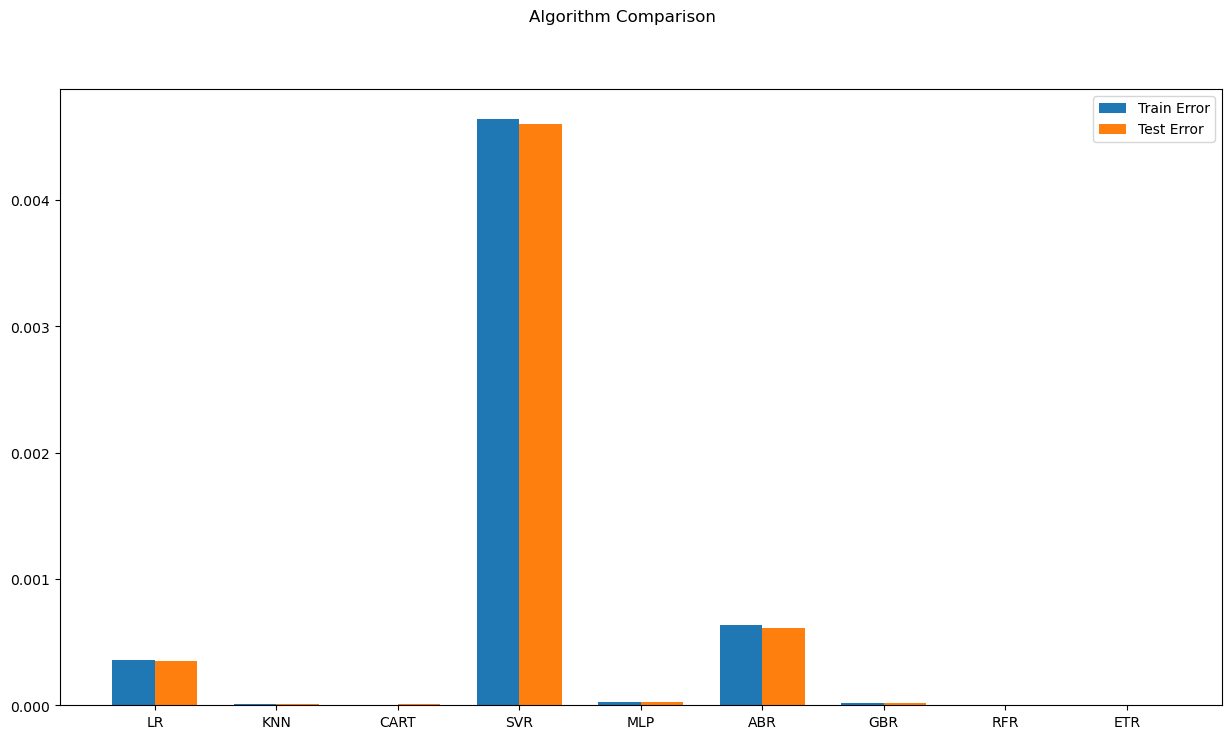

In [64]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names)-2)  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results[0:1] + train_results[3:],  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results[0:1] + test_results[3:], width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names[0:1] + names[3:])
pyplot.show()

multilayer perceptron (MLP) algorithm does a lot better that the linear algorithm. However, the CART and the Forest methods do a very good job as well. Given MLP is one of the best models we perform the grid search for MLP model in the next step.

## Model tuning and finalizing model

In [68]:
'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000035 using {'hidden_layer_sizes': (20, 30, 20)}
-0.000493 (0.000465) with: {'hidden_layer_sizes': (20,)}
-0.000096 (0.000081) with: {'hidden_layer_sizes': (50,)}
-0.000104 (0.000076) with: {'hidden_layer_sizes': (20, 20)}
-0.000035 (0.000039) with: {'hidden_layer_sizes': (20, 30, 20)}


In [70]:
# prepare model
model_tuned = MLPRegressor(hidden_layer_sizes=(20, 30, 20))
model_tuned.fit(X_train, Y_train)

MLPRegressor(hidden_layer_sizes=(20, 30, 20))

In [72]:
# estimate accuracy on validation set
# transform the validation dataset
predictions = model_tuned.predict(X_test)
print(mean_squared_error(Y_test, predictions))

6.424888318183183e-06


We see that the mean error (RMSE) is 6.424888318183183e-06 . Hence, the deep learning model does an excellent job of fitting the Black-Scholes option pricing model. The accuracy may be enhanced with more tuning.

## analysis after removoing volatility data 

In [74]:
X = X[:, :2]

In [76]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

In [78]:
models = []
models.append(('LR', LinearRegression()))
#models.append(('LASSO', Lasso()))
#models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('MLP', MLPRegressor()))
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [80]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.002131 (0.000246) 0.002128 0.002085
KNN: 0.000016 (0.000010) 0.000009 0.000011
CART: 0.000012 (0.000005) 0.000000 0.000009
SVR: 0.005951 (0.000123) 0.005939 0.005879
MLP: 0.000052 (0.000062) 0.000035 0.000031
ABR: 0.000640 (0.000033) 0.000600 0.000570
GBR: 0.000022 (0.000003) 0.000018 0.000021
RFR: 0.000003 (0.000003) 0.000000 0.000002
ETR: 0.000001 (0.000003) 0.000000 0.000000


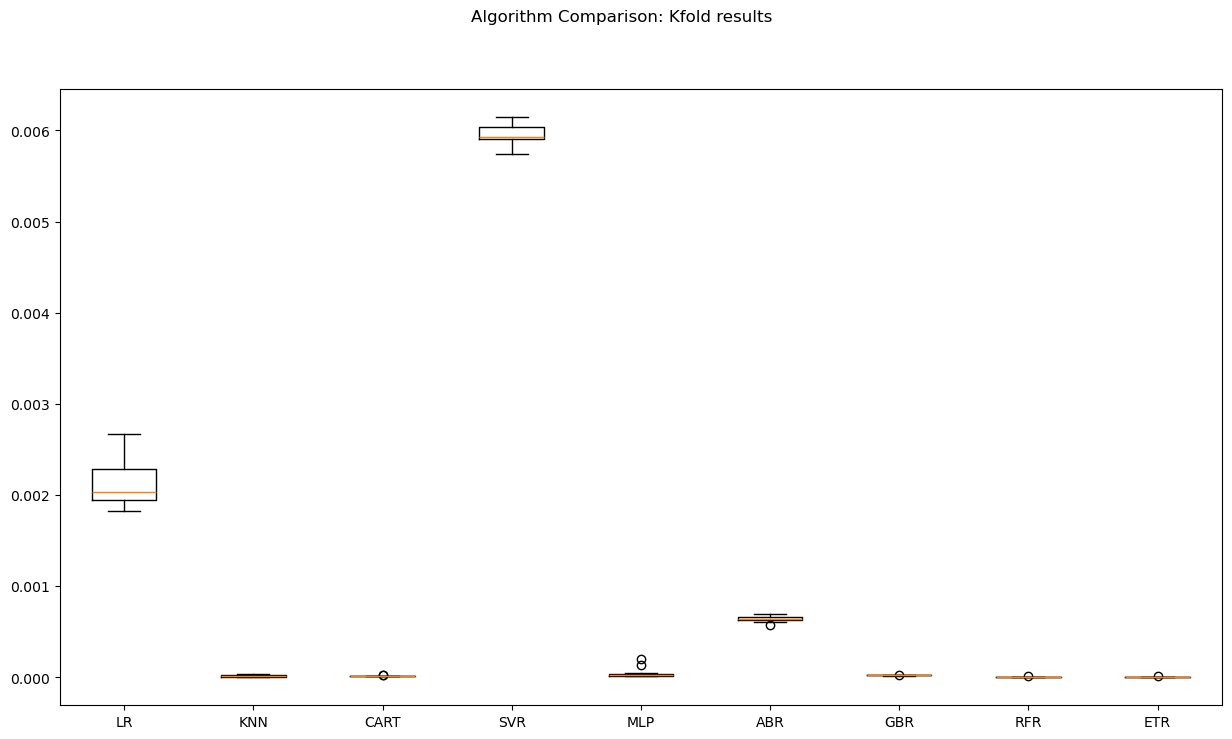

In [82]:

fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

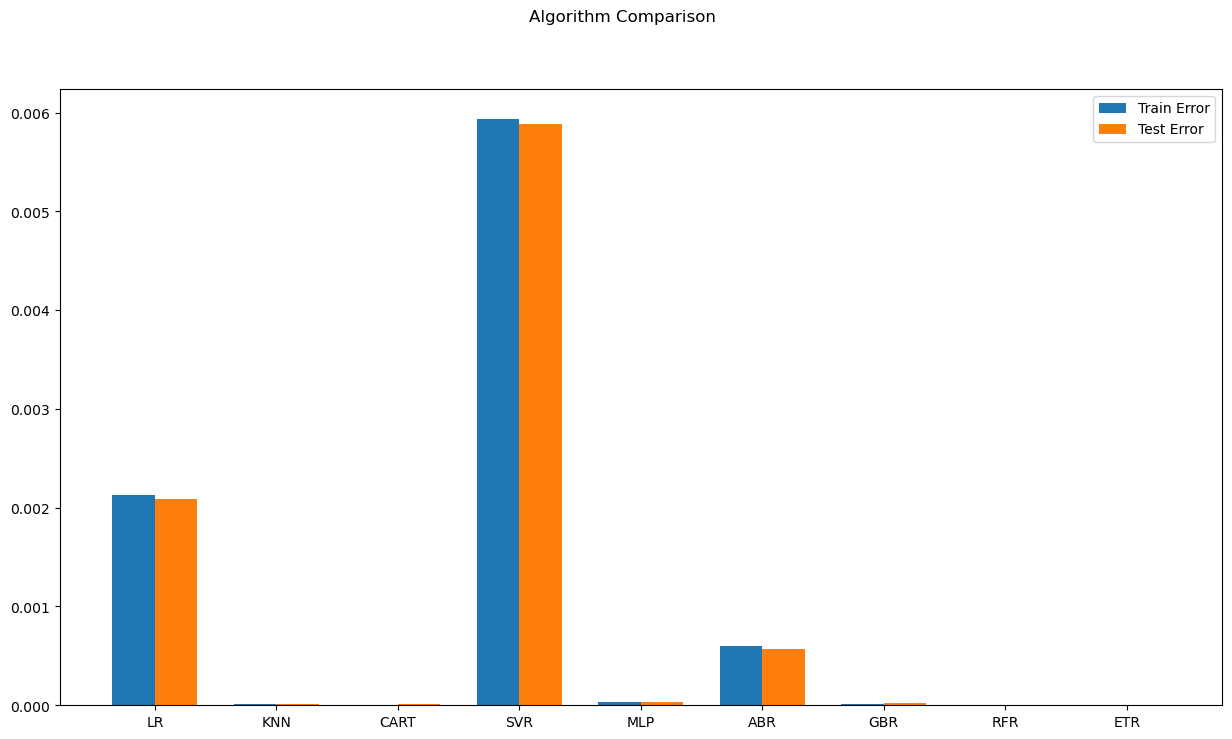

In [84]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

We can see that the linear regression now does a worse job than before, this is expected since we have added a greater amount of non linearity.